In [1]:
# Importing libraries
from importlib import reload
import time
import json

from kcenters import KCenters
from utils import distance, balance_calculation, plot_analysis
from experiments import run_experiments
from data_loader import DataLoader
from fairlet_decomposition import VanillaFairletDecomposition, MCFFairletDecomposition

import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [2]:
source = "bank"
normalize = False
degrees = 20

with open('config.json') as json_file:
    config = json.load(json_file)
    
dl = DataLoader(source=source, fair_column=config[source]['fair_column'],
               fair_values=config[source]['fair_values'], distance_columns=config[source]['distance_columns'])
dl.load(normalize)
blues, reds = dl.split(split_size=tuple(config[source]['split_size']), random_state=config[source]['random_state'])


Distribution of 'marital' column -  [('married', 27214), ('single', 12790)]

Using these features in addition to marital for clustering -  ['age', 'balance', 'duration']

Encoding married as 1, and single as 0.


## k-Centers

#### k-Centers Warmup

[4.123105625617661, 2.23606797749979, 2.23606797749979]


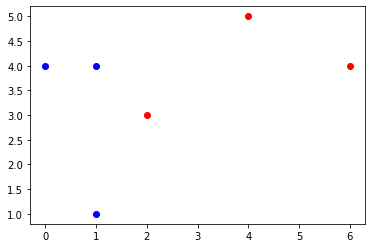

In [3]:
p = [[2, 3], [4, 5], [1,1], [0, 4], [6, 4], [1, 4]]
kcenters = KCenters(k=3)
kcenters.fit(p)

for idx, i in enumerate(p):
    colour = 'blue'
    if idx in kcenters.centers:
        colour = 'red'
    plt.scatter(i[0], i[1], color=colour)
print(kcenters.costs)
plt.show()

#### Unfair k-Centers on the dataset

Time taken for Degree 3 - 0.160 seconds.
Time taken for Degree 4 - 0.194 seconds.
Time taken for Degree 5 - 0.322 seconds.
Time taken for Degree 6 - 0.406 seconds.
Time taken for Degree 7 - 0.524 seconds.
Time taken for Degree 8 - 0.950 seconds.
Time taken for Degree 9 - 1.038 seconds.
Time taken for Degree 10 - 1.268 seconds.
Time taken for Degree 11 - 1.388 seconds.
Time taken for Degree 12 - 1.475 seconds.
Time taken for Degree 13 - 1.890 seconds.
Time taken for Degree 14 - 1.806 seconds.
Time taken for Degree 15 - 1.992 seconds.
Time taken for Degree 16 - 2.519 seconds.
Time taken for Degree 17 - 2.777 seconds.
Time taken for Degree 18 - 3.318 seconds.
Time taken for Degree 19 - 3.617 seconds.
Time taken for Degree 20 - 3.723 seconds.


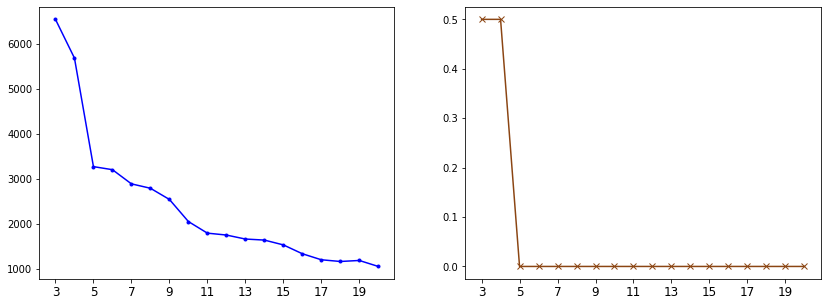

In [4]:
unfair_degrees = []
unfair_costs = []
unfair_balances = []

for degree in range(3, degrees+1, 1):
    start_time = time.time()
    kcenters = KCenters(k=degree)
    kcenters.fit(dl.data_list)
    mapping = kcenters.assign()
    unfair_degrees.append(degree)
    unfair_costs.append(kcenters.costs[-1])
    unfair_balances.append(balance_calculation(dl.data_list, kcenters.centers, mapping))
    print("Time taken for Degree %d - %.3f seconds."%(degree, time.time() - start_time))

plot_analysis(unfair_degrees, unfair_costs, unfair_balances, step_size=2)

### Vanilla Fairlet Decomposition

350 fairlets have been identified.
Time taken for Degree 3 - 0.131 seconds.
Time taken for Degree 4 - 0.151 seconds.
Time taken for Degree 5 - 0.167 seconds.
Time taken for Degree 6 - 0.334 seconds.
Time taken for Degree 7 - 0.376 seconds.
Time taken for Degree 8 - 0.490 seconds.
Time taken for Degree 9 - 0.578 seconds.
Time taken for Degree 10 - 0.647 seconds.
Time taken for Degree 11 - 0.638 seconds.
Time taken for Degree 12 - 0.707 seconds.
Time taken for Degree 13 - 0.773 seconds.
Time taken for Degree 14 - 1.128 seconds.
Time taken for Degree 15 - 1.378 seconds.
Time taken for Degree 16 - 1.140 seconds.
Time taken for Degree 17 - 1.052 seconds.
Time taken for Degree 18 - 1.140 seconds.
Time taken for Degree 19 - 1.690 seconds.
Time taken for Degree 20 - 1.551 seconds.


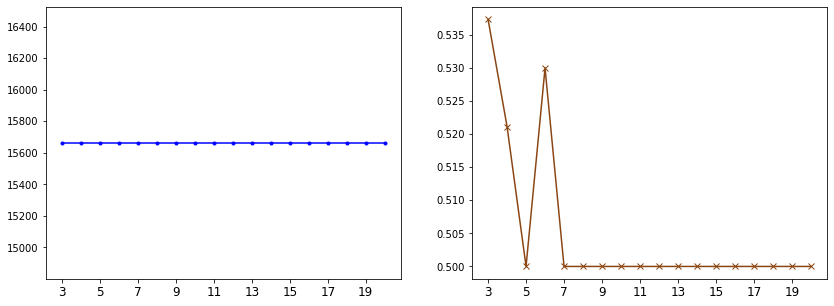

In [5]:
# Instantiating the Vanilla Decomposition per Lemma 3 in NeurIPS 2017 Paper
vfd = VanillaFairletDecomposition(1, 2, blues, reds, dl.data_list)

# Decomposing for fairlets and performing traditional clustering
vanilla_fairlets, vanilla_fairlet_centers, vanilla_fairlet_costs = vfd.decompose()
vanilla_degrees, vanilla_costs, vanilla_balances = run_experiments(degrees, dl.data_list, vanilla_fairlets,
                                                                  vanilla_fairlet_centers)
plot_analysis(vanilla_degrees, vanilla_costs, vanilla_balances, step_size=2)

### MCF Fairlet Decomposition

Graph can't be plotted because the blue nodes exceed 10.
Time taken to compute MCF solution - 389.365 seconds.
350 fairlets have been identified.
Time taken for Degree 3 - 0.165 seconds.
Time taken for Degree 4 - 0.282 seconds.
Time taken for Degree 5 - 0.178 seconds.
Time taken for Degree 6 - 0.294 seconds.
Time taken for Degree 7 - 0.377 seconds.
Time taken for Degree 8 - 0.334 seconds.
Time taken for Degree 9 - 0.639 seconds.
Time taken for Degree 10 - 0.546 seconds.
Time taken for Degree 11 - 0.565 seconds.
Time taken for Degree 12 - 0.737 seconds.
Time taken for Degree 13 - 0.866 seconds.
Time taken for Degree 14 - 0.973 seconds.
Time taken for Degree 15 - 2.387 seconds.
Time taken for Degree 16 - 1.405 seconds.
Time taken for Degree 17 - 1.576 seconds.
Time taken for Degree 18 - 1.828 seconds.
Time taken for Degree 19 - 2.512 seconds.
Time taken for Degree 20 - 2.870 seconds.


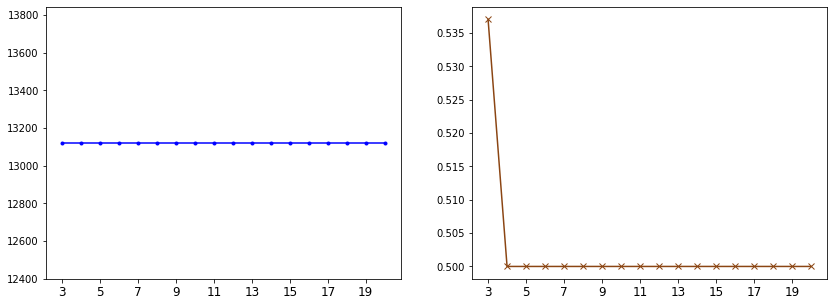

In [6]:
# Instantiating the MCF Decomposition
mcf = MCFFairletDecomposition(blues, reds, 2, config[source]['distance_threshold'], dl.data_list)

# Computing the distance matrix between blue and red nodes
mcf.compute_distances()

# Adding nodes and edges
mcf.build_graph(plot_graph=True)

# Decomposing for fairlets and performing traditional clustering
mcf_fairlets, mcf_fairlet_centers, mcf_fairlet_costs = mcf.decompose()
mcf_degrees, mcf_costs, mcf_balances = run_experiments(degrees, dl.data_list, mcf_fairlets, mcf_fairlet_centers)
plot_analysis(mcf_degrees, mcf_costs, mcf_balances, step_size=2)

## Final Comparison Plot

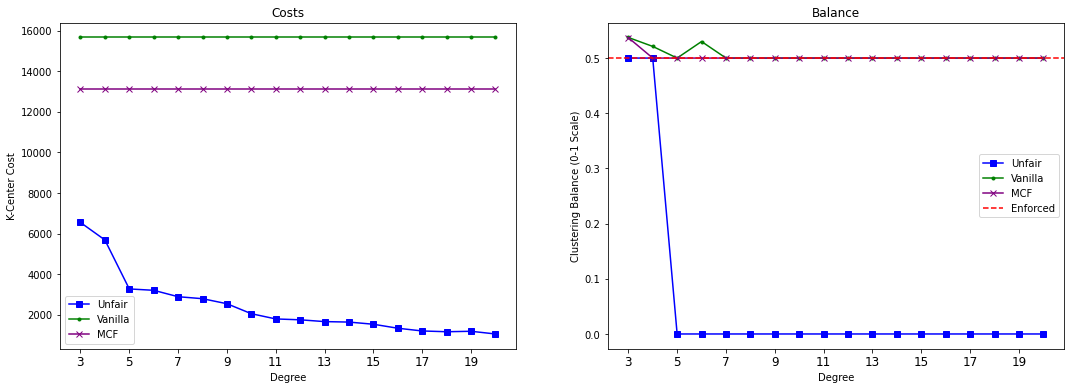

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(unfair_costs, marker='s', color='blue', label="Unfair")
ax[0].plot(vanilla_costs, marker='.', color='green', label="Vanilla")
ax[0].plot(mcf_costs, marker='x', color='purple', label="MCF")
ax[0].set_xticks(list(range(0, len(unfair_degrees), 2))) 
ax[0].set_xticklabels(list(range(min(unfair_degrees), max(unfair_degrees)+1, 2)), fontsize=12)
ax[0].set_title("Costs")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("K-Center Cost")
ax[0].legend()
ax[1].plot(unfair_balances, marker='s', color='blue', label="Unfair")
ax[1].plot(vanilla_balances, marker='.', color='green', label="Vanilla")
ax[1].plot(mcf_balances, marker='x', color='purple', label="MCF")
ax[1].axhline(0.5, color='red', linestyle='--', label="Enforced")
ax[1].set_xticks(list(range(0, len(unfair_degrees), 2))) 
ax[1].set_xticklabels(list(range(min(unfair_degrees), max(unfair_degrees)+1, 2)), fontsize=12)
ax[1].set_title("Balance")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("Clustering Balance (0-1 Scale)")
ax[1].legend()
plt.show()